In [1]:
import numpy as np
import pandas as pd
import mne
import seaborn as sb
import matplotlib.pyplot as plt
from data_util import (
    load_subjects,
    load_subject_data,
    load_data,
    euclidean_alignment,
    label_alignment,
)
from copy import deepcopy

In [2]:
data_dir = "../data/vin/Official"

found 102 subjects


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

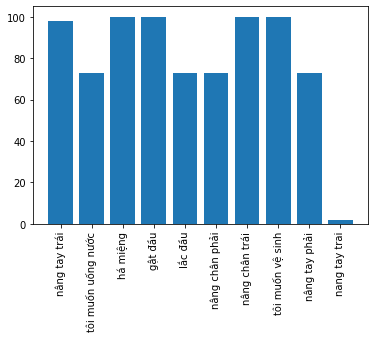

In [3]:
subjects_scenarios = load_subjects(data_dir)
print(f"found {len(subjects_scenarios)} subjects")

scenario_count = dict()
for _, scenarios in subjects_scenarios:
    for scenario in scenarios:
        if scenario in scenario_count:
            scenario_count[scenario] += 1
        else:
            scenario_count[scenario] = 1

plt.bar(scenario_count.keys(), scenario_count.values())
plt.xticks(rotation="vertical")

In [4]:
%%time
use_k_subjects = True  # @param {"type": "boolean"}
use_bn_subjects = False  # @param {"type": "boolean"}

subjects = list()
if use_k_subjects:
    subjects.extend(
        [subject for subject, _ in subjects_scenarios if subject.startswith("K")]
    )
if use_bn_subjects:
    subjects.extend(
        [subject for subject, _ in subjects_scenarios if subject.startswith("BN")]
    )

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    "gật đầu",
    "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
    # "Thinking and Acting",
    # "Resting",
    # "Typing",
]

# channels = [
#     "Fp1", "F7", "F3", "FC5", "FC1", "T7", "C3", "CP5", "CP1", "P7", "P3", "O1",  # left
#     "Fz", "Cz", "Pz", "Oz",  # center
#     "Fp2", "F8", "F4", "FC6", "FC2", "T8", "C4", "CP6", "CP2", "P8", "P4", "O2",  # right
# ]
channels = [
    "Fp1",
    "F7",
    "F3",
    "FC5",
    "FC1",
    "T7",
    "C3",
    "CP5",
    "CP1",
    "P7",
    "P3",
    "O1",  # left
    "Fz",
    "Cz",
    "Pz",
    "Oz",  # center
    "Fp2",
    "F8",
    "F4",
    "FC6",
    "FC2",
    "T8",
    "C4",
    "CP6",
    "CP2",
    "P8",
    "P4",
    "O2",  # right
]

print(f"using {len(channels)} channels")

minimal_trial_duration = 2  # @param
window_duration = 2  # @param
window_stride_duration = 0.25  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

ds = load_data(
    data_dir,
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration,
    window_stride_duration=window_stride_duration,
    start_offset=0,
    stop_offset=0,
    fmin=fmin,
    fmax=fmax,
    resample=None,
    return_raw=False,
    preload=True,
)

subject:   0%|                                                            | 0/103 [00:00<?, ?it/s]

using 28 channels


subject:   4%|██                                                  | 4/103 [00:00<00:07, 14.06it/s]/home/txdat/code/eeg-motor-imagery/notebooks/data_util.py:201: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  10%|████▉                                              | 10/103 [00:00<00:06, 15.29it/s]/home/txdat/code/eeg-motor-imagery/notebooks/data_util.py:201: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/txdat/code/eeg-motor-imagery/notebooks/data_util.py:201: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  19%|█████████▉                                         | 20/103 [00:01<00:05, 14.83it/s]/home/txdat/code

CPU times: user 1min 1s, sys: 9.68 s, total: 1min 10s
Wall time: 1min 21s


In [5]:
ds_info = ds.description
ds_info

,subject,scenario,event,trial,split
0,K001,nâng tay trái,Thinking,0,train
1,K001,nâng tay trái,Thinking,1,train
2,K001,nâng tay trái,Thinking,2,train
3,K001,nâng chân trái,Thinking,0,train
4,K001,nâng chân trái,Thinking,1,train
...,...,...,...,...,...
1502,K375,gật đầu,Thinking,1,train
1503,K375,gật đầu,Thinking,2,train
1504,K375,lắc đầu,Thinking,0,train
1505,K375,lắc đầu,Thinking,1,train


In [6]:
ds_info["subject"].unique()

array(['K001', 'K002', 'K003', 'K004', 'K005', 'K006', 'K007', 'K008',
       'K009', 'K010', 'K011', 'K012', 'K013', 'K014', 'K015', 'K016',
       'K017', 'K018', 'K020', 'K021', 'K022', 'K023', 'K024', 'K025',
       'K026', 'K027', 'K028', 'K299', 'K300', 'K301', 'K302', 'K303',
       'K304', 'K305', 'K306', 'K307', 'K308', 'K309', 'K310', 'K311',
       'K312', 'K313', 'K314', 'K315', 'K316', 'K318', 'K319', 'K320',
       'K321', 'K322', 'K323', 'K324', 'K325', 'K326', 'K327', 'K328',
       'K329', 'K330', 'K331', 'K332', 'K333', 'K334', 'K335', 'K336',
       'K337', 'K338', 'K339', 'K340', 'K342', 'K343', 'K344', 'K350',
       'K351', 'K352', 'K353', 'K354', 'K355', 'K356', 'K357', 'K358',
       'K359', 'K360', 'K361', 'K362', 'K363', 'K364', 'K365', 'K366',
       'K367', 'K368', 'K369', 'K370', 'K371', 'K372', 'K373', 'K374',
       'K375'], dtype=object)

<AxesSubplot:xlabel='subject'>

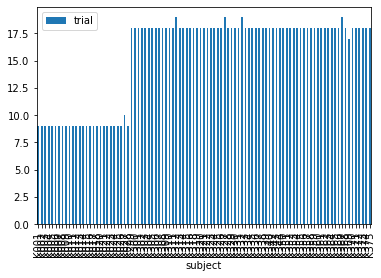

In [7]:
ds_info[["subject", "trial"]].groupby("subject").count().plot.bar()

<AxesSubplot:xlabel='scenario'>

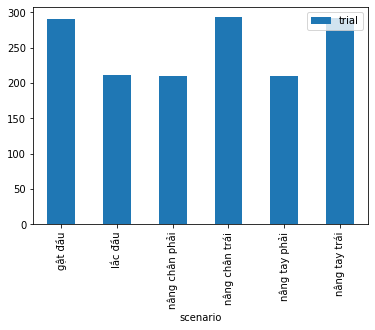

In [8]:
ds_info[["scenario", "trial"]].groupby("scenario").count().plot.bar()

In [10]:
aligned_ds = deepcopy(ds)

In [11]:
target_subject = "K320"  # @param

In [12]:
%%time
label_alignment(
    aligned_ds, target_subject, labeled_trials=[0]
)  # using trial 0 to align

subject: 100%|████████████████████████████████████████████████████| 97/97 [00:05<00:00, 19.04it/s]

CPU times: user 6.9 s, sys: 7.97 s, total: 14.9 s
Wall time: 5.29 s


In [13]:
tgt_idx = ds_info[ds_info["subject"] == target_subject].index
Xtgt = list()
Ytgt = list()
for i in tgt_idx:
    Xtgt.append(aligned_ds.datasets[i].windows.get_data())
    Ytgt.append(np.array(aligned_ds.datasets[i].y, dtype=int))

Xtgt = np.concatenate(Xtgt, axis=0)
Ytgt = np.concatenate(Ytgt, axis=0)

src1_idx = ds_info[ds_info["subject"] == "K304"].index
Xsrc1 = list()
Ysrc1 = list()
for i in src1_idx:
    Xsrc1.append(aligned_ds.datasets[i].windows.get_data())
    Ysrc1.append(np.array(aligned_ds.datasets[i].y, dtype=int))

Xsrc1 = np.concatenate(Xsrc1, axis=0)
Ysrc1 = np.concatenate(Ysrc1, axis=0)

src2_idx = ds_info[ds_info["subject"] == "K305"].index
Xsrc2 = list()
Ysrc2 = list()
for i in src2_idx:
    Xsrc2.append(aligned_ds.datasets[i].windows.get_data())
    Ysrc2.append(np.array(aligned_ds.datasets[i].y, dtype=int))

Xsrc2 = np.concatenate(Xsrc2, axis=0)
Ysrc2 = np.concatenate(Ysrc2, axis=0)

In [14]:
np.bincount(Ytgt), np.bincount(Ysrc1), np.bincount(Ysrc2)

(array([51, 58, 56, 49, 51, 49]),
 array([87, 67, 62, 79, 71, 85]),
 array([61, 61, 61, 57, 53, 60]))

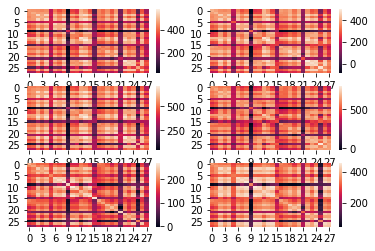

In [15]:
fig, axes = plt.subplots(3, 2)
for i in range(6):
    x = Xtgt[np.where(Ytgt == i)[0]]
    sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[i // 2, i % 2])

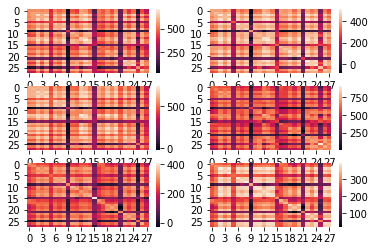

In [16]:
fig, axes = plt.subplots(3, 2)
for i in range(6):
    x = Xsrc1[np.where(Ysrc1 == i)[0]]
    sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[i // 2, i % 2])

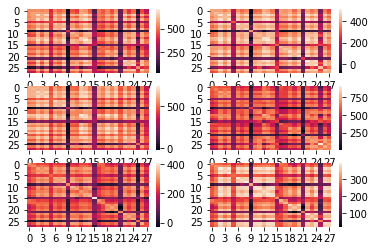

In [17]:
fig, axes = plt.subplots(3, 2)
for i in range(6):
    x = Xsrc2[np.where(Ysrc2 == i)[0]]
    sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[i // 2, i % 2])

In [18]:
euclidean_alignment(aligned_ds)

subject: 100%|████████████████████████████████████████████████████| 97/97 [00:05<00:00, 19.30it/s]


In [19]:
tgt_idx = ds_info[ds_info["subject"] == target_subject].index
Xtgt = list()
Ytgt = list()
for i in tgt_idx:
    Xtgt.append(aligned_ds.datasets[i].windows.get_data())
    Ytgt.append(np.array(aligned_ds.datasets[i].y, dtype=int))

Xtgt = np.concatenate(Xtgt, axis=0)
Ytgt = np.concatenate(Ytgt, axis=0)

src1_idx = ds_info[ds_info["subject"] == "K304"].index
Xsrc1 = list()
Ysrc1 = list()
for i in src1_idx:
    Xsrc1.append(aligned_ds.datasets[i].windows.get_data())
    Ysrc1.append(np.array(aligned_ds.datasets[i].y, dtype=int))

Xsrc1 = np.concatenate(Xsrc1, axis=0)
Ysrc1 = np.concatenate(Ysrc1, axis=0)

src2_idx = ds_info[ds_info["subject"] == "K305"].index
Xsrc2 = list()
Ysrc2 = list()
for i in src2_idx:
    Xsrc2.append(aligned_ds.datasets[i].windows.get_data())
    Ysrc2.append(np.array(aligned_ds.datasets[i].y, dtype=int))

Xsrc2 = np.concatenate(Xsrc2, axis=0)
Ysrc2 = np.concatenate(Ysrc2, axis=0)

<AxesSubplot:>

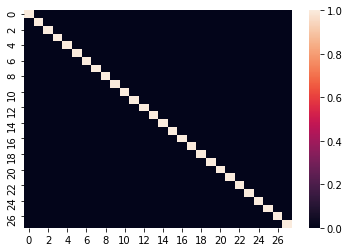

In [20]:
sb.heatmap(np.mean(Xtgt @ Xtgt.transpose((0, 2, 1)), axis=0))

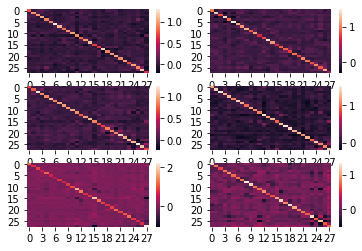

In [21]:
fig, axes = plt.subplots(3, 2)
for i in range(6):
    x = Xtgt[np.where(Ytgt == i)[0]]
    sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[i // 2, i % 2])

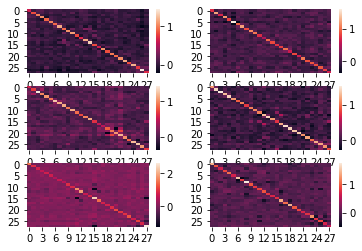

In [22]:
fig, axes = plt.subplots(3, 2)
for i in range(6):
    x = Xsrc1[np.where(Ysrc1 == i)[0]]
    sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[i // 2, i % 2])

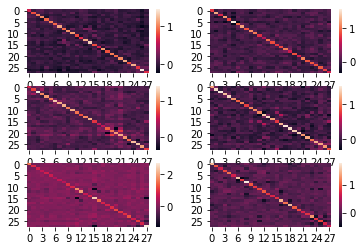

In [23]:
fig, axes = plt.subplots(3, 2)
for i in range(6):
    x = Xsrc2[np.where(Ysrc2 == i)[0]]
    sb.heatmap(np.mean(x @ x.transpose((0, 2, 1)), axis=0), ax=axes[i // 2, i % 2])